# First Attempt
batch size 256 lr 1e-3

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


## Options

In [2]:
classTrainFeatures = basic_features
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'PRI_tau_pt', 'DER_deltar_tau_lep', 'PRI_jet_leading_eta', 'PRI_lep_eta', 'PRI_tau_eta', 'DER_lep_eta_centrality', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 'DER_pt_tot', 'DER_met_phi_centrality', 'PRI_jet_num', 'PRI_met', 'DER_pt_h', 'DER_pt_ratio_lep_tau', 'DER_sum_pt', 'PRI_jet_leading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_all_pt', 'PRI_met_sumet', 'DER_prodeta_jet_jet', 'PRI_lep_pt', 'PRI_jet_subleading_pt', 'PRI_met_phi', 'PRI_jet_leading_phi', 'PRI_lep_phi', 'PRI_jet_subleading_phi', 'PRI_tau_phi']


## Import data

In [3]:
trainData = h5py.File(dirLoc + 'train.hdf5', "r+")
valData = h5py.File(dirLoc + 'val.hdf5', "r+")

## Determine LR

In [ ]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-5,0.1], trainOnWeights=False, verbose=0)

In [4]:
compileArgs['lr'] = 1e-2

## Train classifier

Using cosine annealing
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 0.400561252252
3 New best found: 0.378149787368
6 New best found: 0.371132547385
7 New best found: 0.367546338621
13 New best found: 0.365329898119
14 New best found: 0.363622459261
15 New best found: 0.362778083891
27 New best found: 0.362323531985
28 New best found: 0.361314095019
29 New best found: 0.360359164307
30 New best found: 0.360207265465
31 New best found: 0.360053416153
58 New best found: 0.359536564909
59 New best found: 0.359524779017
60 New best found: 0.359370332884
61 New best found: 0.359236776003
62 New best found: 0.359138851781
Early stopping after 262 epochs
Score is: {'loss': 0.35913885178074928, 'AUC': 0.091134905531261579, 'wAUC': 0.068973002518172732}
Fold took 221.853s

Running fold 2 / 10
1 New best found: 0.401903512347
2 New best found: 0.391692429919
3 New best found: 0.379573900817
6 New best found: 0.375494268449
7 New best found: 0.370313402707
14 New

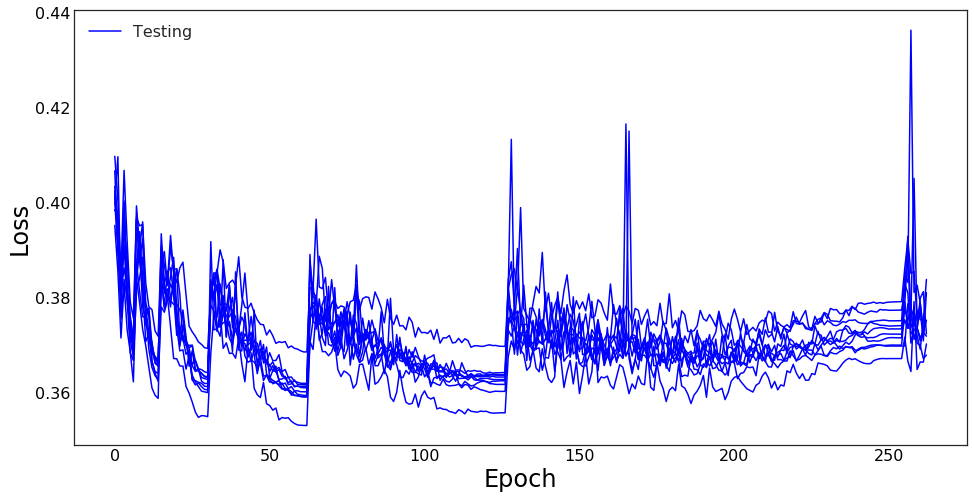

Mean wAUC = 0.0696 +- 0.0007
______________________________________



In [5]:
results, histories = batchTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, cosAnnealMult=2, trainOnWeights=False, patience=200, maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [6]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [7]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 5 with loss = 0.353122269688
Model 1 is 0 with loss = 0.359138851781
Model 2 is 4 with loss = 0.359199308138
Model 3 is 3 with loss = 0.359459306769
Model 4 is 1 with loss = 0.360221377798
Model 5 is 7 with loss = 0.361065514653
Model 6 is 6 with loss = 0.361383996214
Model 7 is 2 with loss = 0.361716643863
Model 8 is 8 with loss = 0.362010562017
Model 9 is 9 with loss = 0.368611306237


## Response on development data

In [8]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000193505530107s per sample

Predicting batch 2 out of 10
Prediction took 0.000175661971811s per sample

Predicting batch 3 out of 10
Prediction took 0.000175414982512s per sample

Predicting batch 4 out of 10
Prediction took 0.000165658700466s per sample

Predicting batch 5 out of 10
Prediction took 0.000176144301891s per sample

Predicting batch 6 out of 10
Prediction took 0.000171178507805s per sample

Predicting batch 7 out of 10
Prediction took 0.000160073745251s per sample

Predicting batch 8 out of 10
Prediction took 0.000167666175877s per sample

Predicting batch 9 out of 10
Prediction took 0.000181970909134s per sample

Predicting batch 10 out of 10
Prediction took 0.000160533587058s per sample



In [9]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData)),
                                                            roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData), sample_weight=getFeature('weights', trainData)))

Training ROC AUC: unweighted 0.913288160645, weighted 0.934247941282


## Response on val data

In [10]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000180698823929s per sample

Predicting batch 2 out of 10
Prediction took 0.000184695577621s per sample

Predicting batch 3 out of 10
Prediction took 0.000198355388641s per sample

Predicting batch 4 out of 10
Prediction took 0.00016278181076s per sample

Predicting batch 5 out of 10
Prediction took 0.000156305646896s per sample

Predicting batch 6 out of 10
Prediction took 0.000252939605713s per sample

Predicting batch 7 out of 10
Prediction took 0.000158601379395s per sample

Predicting batch 8 out of 10
Prediction took 0.000162871599197s per sample

Predicting batch 9 out of 10
Prediction took 0.00016643781662s per sample

Predicting batch 10 out of 10
Prediction took 0.000167182588577s per sample



In [11]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData), getFeature('pred', valData)),
                                                           roc_auc_score(getFeature('targets', valData), getFeature('pred', valData), sample_weight=getFeature('weights', valData)))

Testing ROC AUC: unweighted 0.908779216407, weighted 0.929871759305


## Evaluation

### Import in dataframe

In [12]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['gen_weight'] = getFeature('weights', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [13]:
devData = convertToDF(trainData)
valData = convertToDF(valData)

200000 candidates loaded
50000 candidates loaded


In [14]:
sigVal = (valData.gen_target == 1)
bkgVal = (valData.gen_target == 0)

### MVA distributions

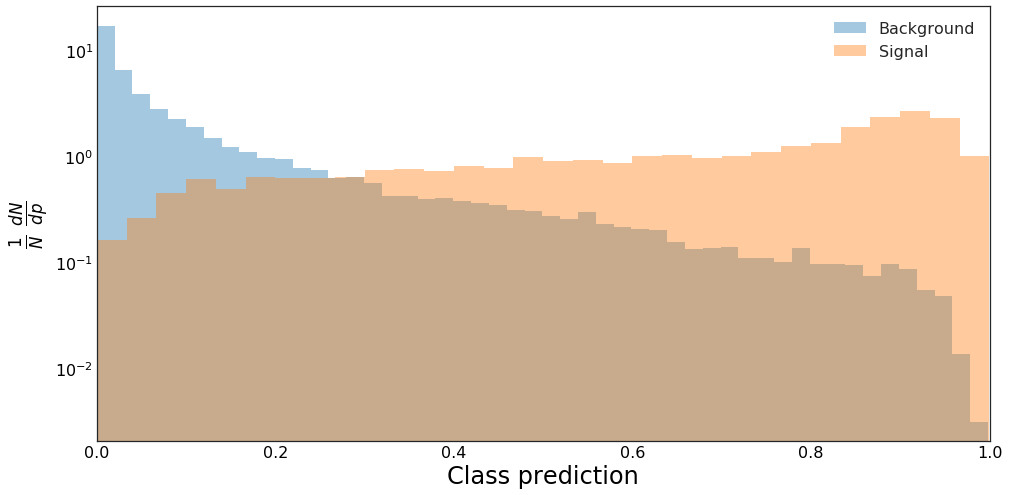

In [15]:
getClassPredPlot([valData[bkgVal], valData[sigVal]], weightName='gen_weight')

In [16]:
def AMS(s, b):
    """ Approximate Median Significance defined as:
        AMS = sqrt(
                2 { (s + b + b_r) log[1 + (s/(b+b_r))] - s}
              )        
    where b_r = 10, b = background, s = signal, log is natural logarithm """
    
    br = 10.0
    radicand = 2 *( (s+b+br) * math.log (1.0 + s/(b+br)) -s)
    if radicand < 0:
        print 'radicand is negative. Exiting'
        exit()
    else:
        return math.sqrt(radicand)
    
def amsScan(inData, res=0.0001):
    best = [0,-1]
    for i in np.linspace(0.,1.,1./res):
        ams = AMS(np.sum(inData.loc[(inData['pred_class'] >= i) & sigVal, 'gen_weight']),
                  np.sum(inData.loc[(inData['pred_class'] >= i) & bkgVal, 'gen_weight']))
        if ams > best[1]:
            best = [i, ams]
    print best

In [17]:
amsScan(valData)

/home/giles/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


[0.83498349834983498, 1.640540639862582]


In [23]:
def scoreTest(ensemble, weights, features, cut, name):
    testData = pandas.read_csv('../Data/test.csv')
    with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
        inputPipe = pickle.load(fin)

    testData['pred_class'] = ensemblePredict(inputPipe.transform(testData[features].values.astype('float32')), ensemble, weights)    	

    testData['Class'] = 'b'
    testData.loc[testData.pred_class >= cut, 'Class'] = 's'

    testData.sort_values(by=['pred_class'], inplace=True)
    testData['RankOrder']=range(1, len(testData)+1)
    testData.sort_values(by=['EventId'], inplace=True)

    testData.to_csv(dirLoc + name + '_test.csv', columns=['EventId', 'RankOrder', 'Class'], index=False)

In [24]:
scoreTest(ensemble, weights, classTrainFeatures, 0.83498349834983498, 'Model_0_Basic_Features_256_1e-2_swish_mult2_200E')

## Save classified data

In [ ]:
name = dirLoc + signal + "_" + channel + "_" + varSet + '_' + classModel + '_classifiedData.csv'
print "Saving data to", name
valData.to_csv(name, columns=['gen_target', 'gen_weight', 'gen_sample', 'pred_class'])

## Save/load

In [ ]:
name = "weights/DNN_" + signal + "_" + channel + "_" + varSet + '_' + classModel
print name

### Save

In [ ]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=1)

### Load

In [ ]:
ensemble, weights, compileArgs, inputPipe, outputPipe = loadEnsemble(name)